In [1]:
import torch
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [2]:
from torch.utils.data import Dataset, DataLoader

class AutoencoderDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        return x, x

train_loader = DataLoader(AutoencoderDataset(train_data), batch_size=32,
                          shuffle=True)
valid_loader = DataLoader(AutoencoderDataset(valid_data), batch_size=32)
test_loader = DataLoader(AutoencoderDataset(test_data), batch_size=32)



In [3]:
import torch.nn as nn

torch.manual_seed(42)  # extra code – ensures reproducibility

codings_dim = 32
generator = nn.Sequential(
    nn.Linear(codings_dim, 128), nn.ReLU(),
    nn.Linear(128, 256), nn.ReLU(),
    nn.Linear(256, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))).to(device)
discriminator = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 1), nn.Sigmoid()).to(device)



In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def plot_image(image):
    plt.imshow(image.permute(1, 2, 0).cpu(), cmap="binary")
    plt.axis("off")

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(image)
        
def train_gan(generator, discriminator, train_loader, codings_dim, n_epochs=20,
              g_lr=1e-3, d_lr=5e-4):
    criterion = nn.BCELoss()
    generator_opt = torch.optim.NAdam(generator.parameters(), lr=g_lr)
    discriminator_opt = torch.optim.NAdam(discriminator.parameters(), lr=d_lr)
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}", end="")
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            pred_real = discriminator(real_images)
            batch_size = real_images.size(0)
            ones = torch.ones(batch_size, 1, device=device)
            real_loss = criterion(pred_real, ones)
            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings).detach()
            pred_fake = discriminator(fake_images)
            zeros = torch.zeros(batch_size, 1, device=device)
            fake_loss = criterion(pred_fake, zeros)
            discriminator_loss = real_loss + fake_loss
            discriminator_opt.zero_grad()
            discriminator_loss.backward()
            discriminator_opt.step()

            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings)
            for p in discriminator.parameters():
                p.requires_grad = False
            pred_fake = discriminator(fake_images)
            generator_loss = criterion(pred_fake, ones)
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
            for p in discriminator.parameters():
                p.requires_grad = True
        print(f" | discriminator loss: {discriminator_loss.item():.4f}", end="")
        print(f" | generator loss: {generator_loss.item():.4f}")
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            plot_multiple_images(fake_images.detach(), 8)
            plt.show()



Epoch 1/20 | discriminator loss: 0.6369 | generator loss: 1.2162


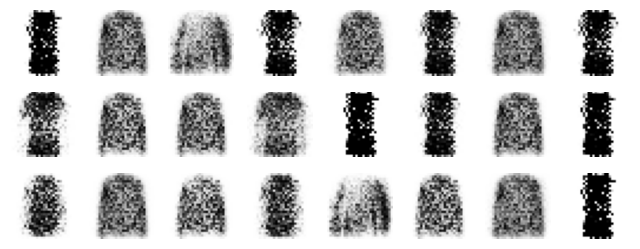

Epoch 2/20 | discriminator loss: 0.7448 | generator loss: 3.2630
Epoch 3/20 | discriminator loss: 0.4849 | generator loss: 3.5376
Epoch 4/20 | discriminator loss: 0.6390 | generator loss: 2.0343
Epoch 5/20 | discriminator loss: 0.9335 | generator loss: 2.4868
Epoch 6/20 | discriminator loss: 0.6415 | generator loss: 2.4402
Epoch 7/20 | discriminator loss: 0.5879 | generator loss: 2.4034
Epoch 8/20 | discriminator loss: 0.7724 | generator loss: 1.4772
Epoch 9/20 | discriminator loss: 0.7384 | generator loss: 2.2236
Epoch 10/20 | discriminator loss: 0.7838 | generator loss: 1.7576
Epoch 11/20 | discriminator loss: 0.9814 | generator loss: 1.3743


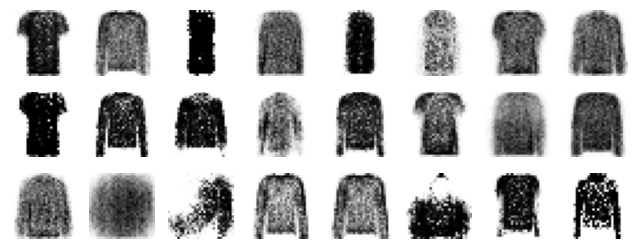

Epoch 12/20 | discriminator loss: 0.9133 | generator loss: 1.8503
Epoch 13/20 | discriminator loss: 0.8433 | generator loss: 1.8546
Epoch 14/20 | discriminator loss: 0.8841 | generator loss: 1.9160
Epoch 15/20 | discriminator loss: 1.0379 | generator loss: 1.4621
Epoch 16/20 | discriminator loss: 0.8763 | generator loss: 1.3035
Epoch 17/20 | discriminator loss: 1.1055 | generator loss: 1.9247
Epoch 18/20 | discriminator loss: 0.6981 | generator loss: 1.6087
Epoch 19/20 | discriminator loss: 0.6265 | generator loss: 1.5355
Epoch 20/20 | discriminator loss: 0.8709 | generator loss: 1.6617


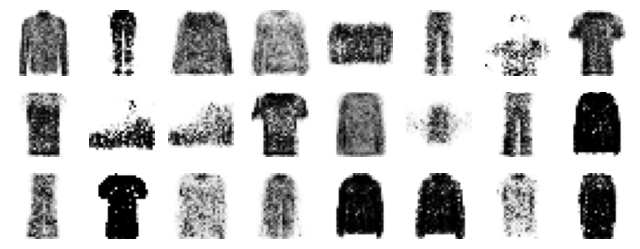

In [5]:
train_gan(generator, discriminator, train_loader, codings_dim)

Conv GAN

Epoch 1/20 | discriminator loss: 1.3440 | generator loss: 0.7370


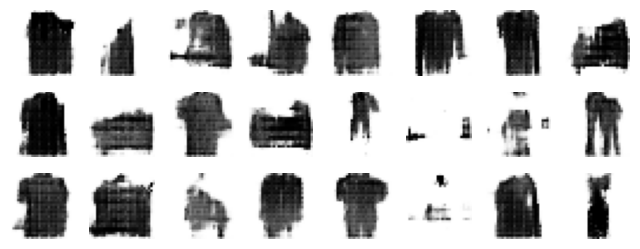

Epoch 2/20 | discriminator loss: 1.0998 | generator loss: 1.0049
Epoch 3/20 | discriminator loss: 0.8233 | generator loss: 1.1612
Epoch 4/20 | discriminator loss: 0.9605 | generator loss: 1.2000
Epoch 5/20 | discriminator loss: 0.9854 | generator loss: 1.2672
Epoch 6/20 | discriminator loss: 0.9046 | generator loss: 1.5052
Epoch 7/20 | discriminator loss: 0.9514 | generator loss: 1.2778
Epoch 8/20 | discriminator loss: 0.6917 | generator loss: 1.6697
Epoch 9/20 | discriminator loss: 0.6590 | generator loss: 1.4526
Epoch 10/20 | discriminator loss: 0.8166 | generator loss: 1.5177
Epoch 11/20 | discriminator loss: 0.5277 | generator loss: 1.2074


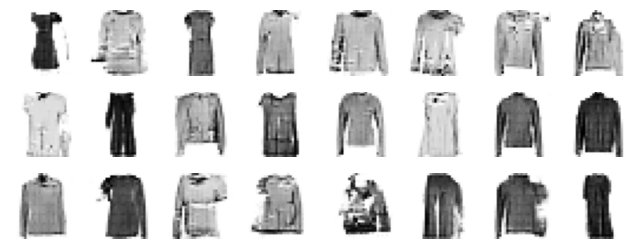

Epoch 12/20 | discriminator loss: 0.7754 | generator loss: 1.4363
Epoch 13/20 | discriminator loss: 0.8213 | generator loss: 1.7445
Epoch 14/20 | discriminator loss: 0.8229 | generator loss: 1.5065
Epoch 15/20 | discriminator loss: 0.5132 | generator loss: 1.8489
Epoch 16/20 | discriminator loss: 0.8012 | generator loss: 1.5123
Epoch 17/20 | discriminator loss: 0.6477 | generator loss: 1.7618
Epoch 18/20 | discriminator loss: 0.4669 | generator loss: 1.9101
Epoch 19/20 | discriminator loss: 0.7035 | generator loss: 1.9309
Epoch 20/20 | discriminator loss: 0.5524 | generator loss: 1.9576


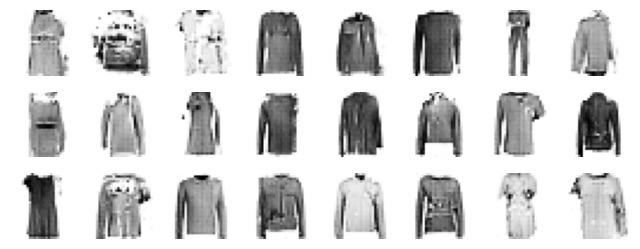

In [6]:
torch.manual_seed(1)  # extra code – ensures reproducibility

dc_codings_dim = 100

dc_generator = nn.Sequential(
    nn.Linear(dc_codings_dim, 128 * 7 * 7),
    nn.Unflatten(dim=1, unflattened_size=(128, 7, 7)),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1,
                   output_padding=1), nn.Sigmoid()).to(device)
dc_discriminator = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2), nn.ReLU(),  # 32 x 14 x 14
    nn.Dropout(0.4),
    nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), nn.ReLU(),  # 64 x 7 x 7
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 1), nn.Sigmoid()).to(device)

torch.manual_seed(42)
train_gan(dc_generator, dc_discriminator, train_loader, dc_codings_dim)

